In [1]:
!ls -l ../input/fastai-2012-wheel

!ls -l ../input/fast-v2-offline

total 696060
-rw-r--r-- 1 nobody nogroup    485541 Sep 23 00:03 allennlp-1.1.0-py3-none-any.whl
-rw-r--r-- 1 nobody nogroup    184084 Sep 23 00:03 fastai-2.0.12-py3-none-any.whl
-rw-r--r-- 1 nobody nogroup     40654 Sep 23 00:03 fastcore-1.0.11-py3-none-any.whl
-rw-r--r-- 1 nobody nogroup    195132 Sep 23 00:03 kornia-0.4.0-py2.py3-none-any.whl
-rw-r--r-- 1 nobody nogroup   3036287 Sep 23 00:03 tokenizers-0.8.1-cp37-cp37m-manylinux1_x86_64.whl
-rw-r--r-- 1 nobody nogroup 708038680 Sep 23 00:03 torch-1.6.0cu101-cp37-cp37m-linux_x86_64.whl
-rw-r--r-- 1 nobody nogroup    769034 Sep 23 00:03 transformers-3.0.2-py3-none-any.whl
total 737464
-rw-r--r-- 1 nobody nogroup     14757 Sep  5 07:39 dataclasses-0.6-py3-none-any.whl
-rw-r--r-- 1 nobody nogroup    353779 Sep  5 07:39 fastai-2.0.8-py3-none-any.whl
-rw-r--r-- 1 nobody nogroup     37043 Sep  5 07:39 fastcore-1.0.1-py3-none-any.whl
-rw-r--r-- 1 nobody nogroup     12630 Sep  5 07:39 fastprogress-1.0.0-py3-none-any.whl
-rw-r--r-- 1 nobody n

In [2]:
!pip uninstall fastai transformers allennlp kornia tokenizers -y

!pip install ../input/fastai-2012-wheel/torch-1.6.0cu101-cp37-cp37m-linux_x86_64.whl

!pip install ../input/fastai-2012-wheel/tokenizers-0.8.1-cp37-cp37m-manylinux1_x86_64.whl

!pip install ../input/fastai-2012-wheel/kornia-0.4.0-py2.py3-none-any.whl

!pip install ../input/fastai-2012-wheel/fastcore-1.0.11-py3-none-any.whl

!pip install ../input/fast-v2-offline/dataclasses-0.6-py3-none-any.whl

!pip install ../input/fast-v2-offline/torchvision-0.7.0-cp37-cp37m-manylinux1_x86_64.whl

!pip install ../input/fastai-2012-wheel/fastai-2.0.12-py3-none-any.whl

Found existing installation: fastai 2.0.13
Uninstalling fastai-2.0.13:
  Successfully uninstalled fastai-2.0.13
Found existing installation: transformers 3.0.2
Uninstalling transformers-3.0.2:
  Successfully uninstalled transformers-3.0.2
Found existing installation: allennlp 1.1.0
Uninstalling allennlp-1.1.0:
  Successfully uninstalled allennlp-1.1.0
Found existing installation: kornia 0.4.0
Uninstalling kornia-0.4.0:
  Successfully uninstalled kornia-0.4.0
Found existing installation: tokenizers 0.8.1rc1
Uninstalling tokenizers-0.8.1rc1:
  Successfully uninstalled tokenizers-0.8.1rc1
Processing /kaggle/input/fastai-2012-wheel/torch-1.6.0cu101-cp37-cp37m-linux_x86_64.whl
  Attempting uninstall: torch
    Found existing installation: torch 1.6.0
    Uninstalling torch-1.6.0:
      Successfully uninstalled torch-1.6.0
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

W

In [3]:
import fastai
fastai.__version__

'2.0.12'

In [4]:
import torch
torch.cuda.is_available()

True

In [5]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
from fastai.tabular.all import *

import pandas as pd
import numpy as np
import os, re

from os.path import isdir, isfile, basename, dirname

from glob import glob
from pathlib import Path as P
from tqdm.notebook import tqdm

import seaborn as sns

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss


def random_seed(seed_value, use_cuda=True):
    # https://forums.fast.ai/t/solved-reproducibility-where-is-the-randomness-coming-in/31628/5
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    random.seed(seed_value) # Python
    if use_cuda: 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['figure.dpi'] = 150
pd.options.display.max_colwidth = 100
pd.options.display.max_columns = 100


PATH = '../input/lish-moa'
print(glob(f'{PATH}/*'))

scored = pd.read_csv(f'{PATH}/train_targets_scored.csv')
train_feat = pd.read_csv(f'{PATH}/train_features.csv')
test = pd.read_csv(f'{PATH}/test_features.csv').set_index('sig_id')

train = pd.merge(train_feat, scored, on='sig_id')

cont_names = train_feat.filter(regex='g-|c-').columns.to_list()
y_names_scored = scored.set_index('sig_id').columns.to_list()
y_names = y_names_scored

random_seed(42)


['../input/lish-moa/test_features.csv', '../input/lish-moa/sample_submission.csv', '../input/lish-moa/train_features.csv', '../input/lish-moa/train_targets_scored.csv', '../input/lish-moa/train_targets_nonscored.csv']


In [7]:
def predict(learn, data):
    dl = learn.dls.test_dl(data)
    pred, _ = learn.get_preds(dl=dl)        
    pred_scored = pred[:,:len(y_names_scored)].numpy()
    return pred_scored

def create_submission(learn=None, test=None, from_numpy=False, fn=None):
    if fn is None:
        fn = 'submission.csv'
    if from_numpy is False:       
        pred_scored = predict(learn, test)
    else:
        pred_scored = from_numpy
    submission = pd.read_csv(f'{PATH}/sample_submission.csv').set_index('sig_id')
    submission.loc[:, y_names_scored] = pred_scored
    submission.loc[test['cp_type']=='ctl_vehicle', y_names_scored] = 0
    submission.to_csv(fn)
    return pred_scored

In [8]:
config = tabular_config(ps=[0.8, 0.6] , embed_p=0.5)
layers = [2018, 1024]
batch_size = 128

splits = RandomSplitter(valid_pct=0.1)(range_of(train))

to = TabularPandas(train, y_names=y_names,
     cat_names = ['cp_type', 'cp_time', 'cp_dose'],
     cont_names = cont_names,
     procs = [Categorify, FillMissing, Normalize],
     splits = splits)

dls = to.dataloaders(bs=batch_size)

callbacks = [
    EarlyStoppingCallback(monitor='valid_loss', min_delta=1e-5, patience=10),    
    ReduceLROnPlateau(monitor='valid_loss', min_delta=0.1, patience=5, min_lr=1e-8),
    SaveModelCallback(name='model'),
] 

def fitting_procedure(learn):
    learn.lr_find()
    show()
    learn.fit_one_cycle(10, 2e-2, wd=0.1)
    learn.fit_one_cycle(10, slice(1e-3), wd=0.2)
    learn.recorder.plot_loss(with_valid=True)
    show()
    learn.fit(100, slice(1e-3), wd=0.5, cbs=callbacks)
    learn.recorder.plot_loss(with_valid=True)
    show()
    learn.load('model')
    return learn

============================== Round 0 ==============================
TabularModel(
  (embeds): ModuleList(
    (0): Embedding(3, 3)
    (1): Embedding(4, 3)
    (2): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.5, inplace=False)
  (bn_cont): BatchNorm1d(872, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): BatchNorm1d(881, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.8, inplace=False)
      (2): Linear(in_features=881, out_features=2018, bias=False)
      (3): ReLU(inplace=True)
    )
    (1): LinBnDrop(
      (0): BatchNorm1d(2018, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.6, inplace=False)
      (2): Linear(in_features=2018, out_features=1024, bias=False)
      (3): ReLU(inplace=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=1024, out_features=206, bias=True)
    )
  )
)


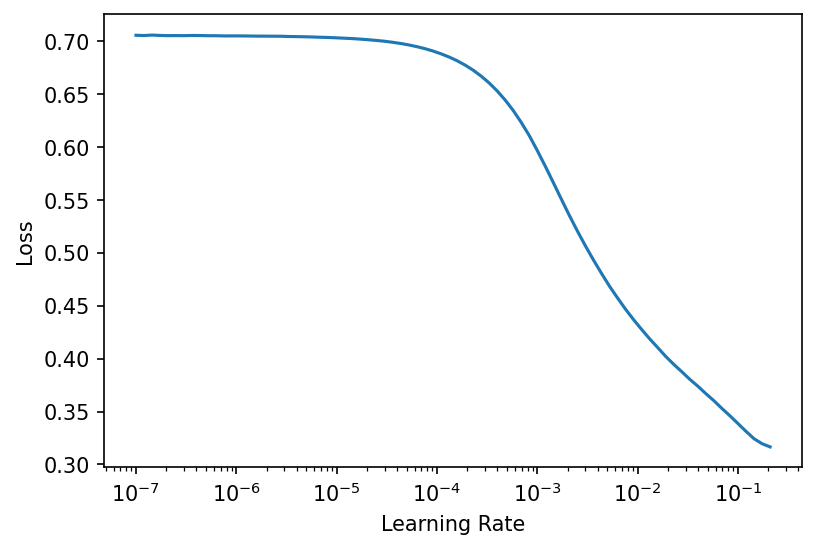

epoch,train_loss,valid_loss,time
0,0.024267,0.020362,00:02
1,0.023208,0.019365,00:02
2,0.019970,0.018304,00:02
3,0.019324,0.017908,00:02
4,0.018746,0.017431,00:02
5,0.018030,0.017318,00:02
6,0.017561,0.016885,00:02
7,0.017335,0.016459,00:02
8,0.016996,0.016421,00:02
9,0.016692,0.016316,00:02


epoch,train_loss,valid_loss,time
0,0.016841,0.016308,00:02
1,0.016952,0.016281,00:02
2,0.016653,0.016212,00:02
3,0.016857,0.016221,00:02
4,0.016711,0.016125,00:02
5,0.016418,0.016101,00:02
6,0.016693,0.016048,00:02
7,0.016671,0.016094,00:02
8,0.016580,0.016054,00:02
9,0.016419,0.016022,00:02


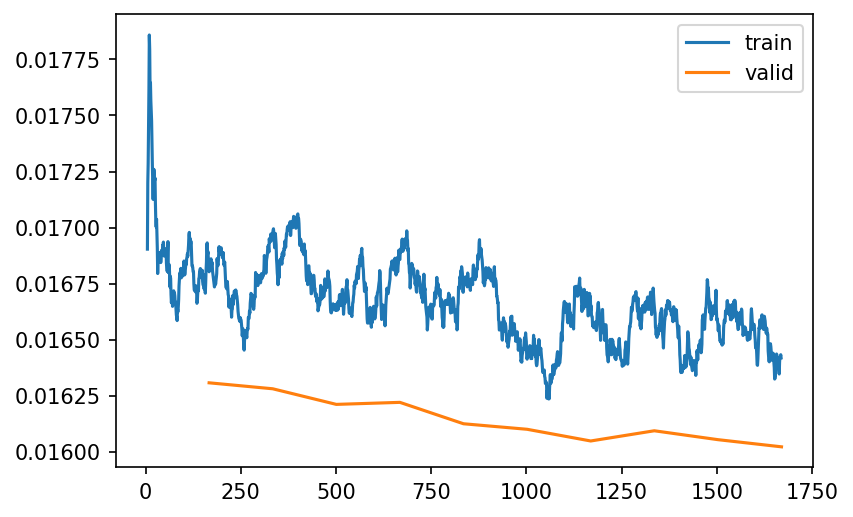

epoch,train_loss,valid_loss,time
0,0.016589,0.016025,00:02
1,0.016515,0.016069,00:02
2,0.016416,0.016077,00:02
3,0.016435,0.016013,00:02
4,0.016496,0.015939,00:02
5,0.016335,0.016052,00:02
6,0.016142,0.015920,00:02
7,0.016427,0.015844,00:02
8,0.016296,0.015878,00:02
9,0.016134,0.015865,00:03


Better model found at epoch 0 with valid_loss value: 0.016024701297283173.
Better model found at epoch 3 with valid_loss value: 0.016013018786907196.
Better model found at epoch 4 with valid_loss value: 0.01593911089003086.
Epoch 5: reducing lr to 0.0001
Better model found at epoch 6 with valid_loss value: 0.015920255333185196.
Better model found at epoch 7 with valid_loss value: 0.015843508765101433.
Epoch 10: reducing lr to 1e-05
Epoch 15: reducing lr to 1.0000000000000002e-06
No improvement since epoch 7: early stopping


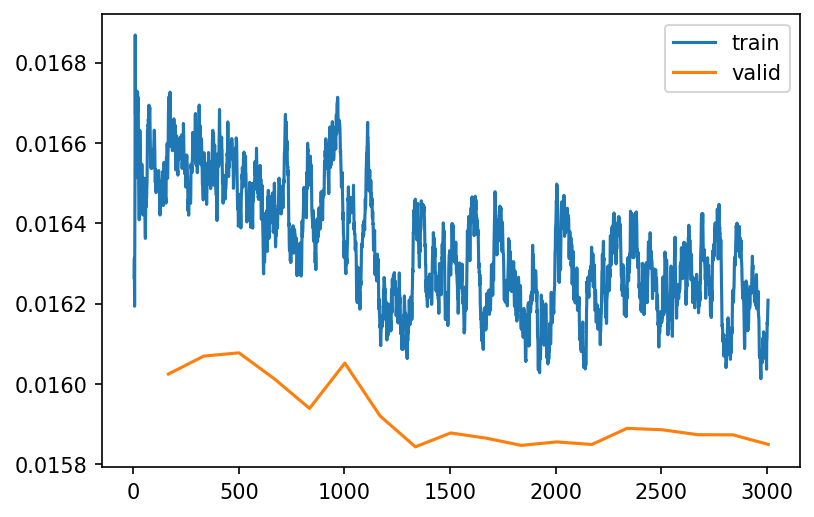

Best validation score: 0.015843508765101433.


============================== Round 1 ==============================
TabularModel(
  (embeds): ModuleList(
    (0): Embedding(3, 3)
    (1): Embedding(4, 3)
    (2): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.5, inplace=False)
  (bn_cont): BatchNorm1d(872, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): BatchNorm1d(881, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.8, inplace=False)
      (2): Linear(in_features=881, out_features=2018, bias=False)
      (3): ReLU(inplace=True)
    )
    (1): LinBnDrop(
      (0): BatchNorm1d(2018, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.6, inplace=False)
      (2): Linear(in_features=2018, out_features=1024, bias=False)
      (3): ReLU(inplace=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=1024, out_features=206, bias=True)
    )
  )
)


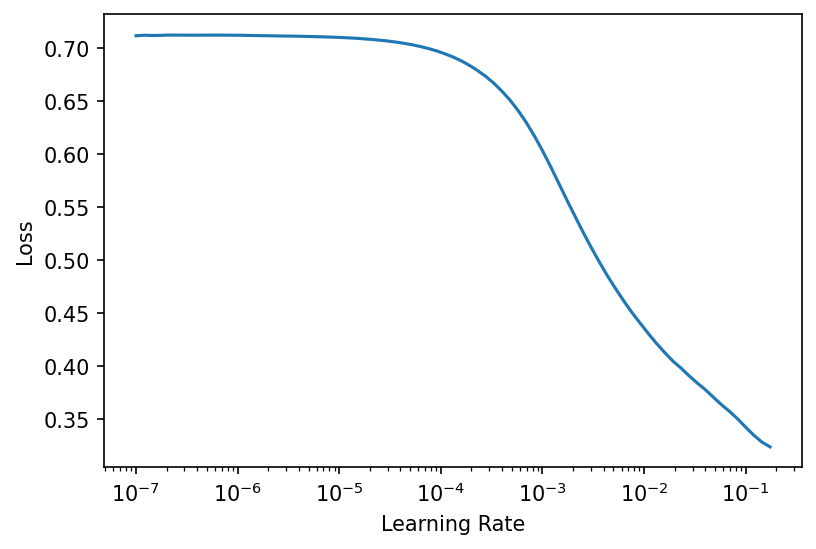

epoch,train_loss,valid_loss,time
0,0.024555,0.019749,00:02
1,0.022431,0.018886,00:02
2,0.020762,0.018838,00:02
3,0.018899,0.017803,00:02
4,0.018635,0.017796,00:02
5,0.018092,0.017238,00:02
6,0.017972,0.016935,00:02
7,0.017292,0.016547,00:02
8,0.016957,0.016285,00:02
9,0.016860,0.016312,00:02


epoch,train_loss,valid_loss,time
0,0.016738,0.016275,00:02
1,0.016731,0.016239,00:02
2,0.016799,0.016190,00:02
3,0.016697,0.016189,00:02
4,0.016866,0.016130,00:02
5,0.016594,0.016059,00:02
6,0.016664,0.016035,00:02
7,0.016542,0.016007,00:02
8,0.016273,0.016045,00:02
9,0.016483,0.016011,00:02


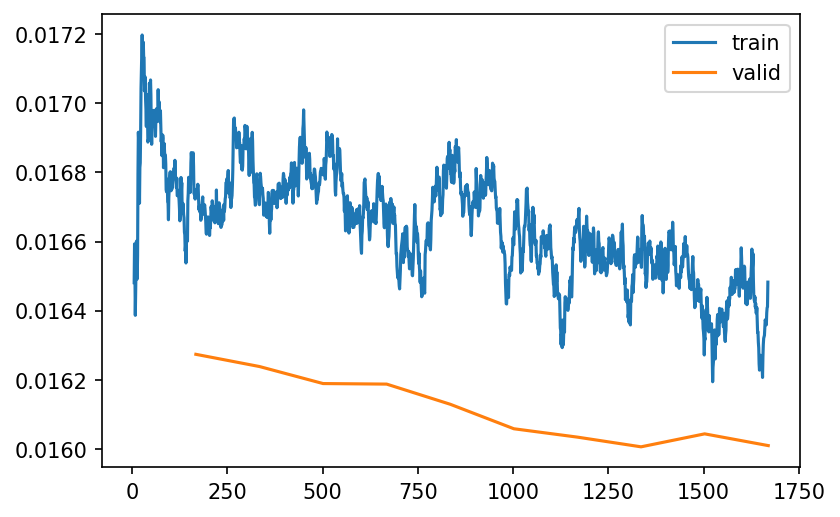

epoch,train_loss,valid_loss,time
0,0.016616,0.016040,00:02
1,0.016587,0.016105,00:02
2,0.016593,0.015982,00:02
3,0.016550,0.015998,00:02
4,0.016490,0.016020,00:02
5,0.016365,0.015958,00:02
6,0.016323,0.015913,00:02
7,0.016312,0.015872,00:02
8,0.016320,0.015817,00:02
9,0.016401,0.015836,00:02


Better model found at epoch 0 with valid_loss value: 0.016040466725826263.
Better model found at epoch 2 with valid_loss value: 0.01598196104168892.
Epoch 5: reducing lr to 0.0001
Better model found at epoch 5 with valid_loss value: 0.015957873314619064.
Better model found at epoch 6 with valid_loss value: 0.015913015231490135.
Better model found at epoch 7 with valid_loss value: 0.015871554613113403.
Better model found at epoch 8 with valid_loss value: 0.015817193314433098.
Epoch 10: reducing lr to 1e-05
Epoch 15: reducing lr to 1.0000000000000002e-06
Better model found at epoch 16 with valid_loss value: 0.01581701450049877.
No improvement since epoch 8: early stopping


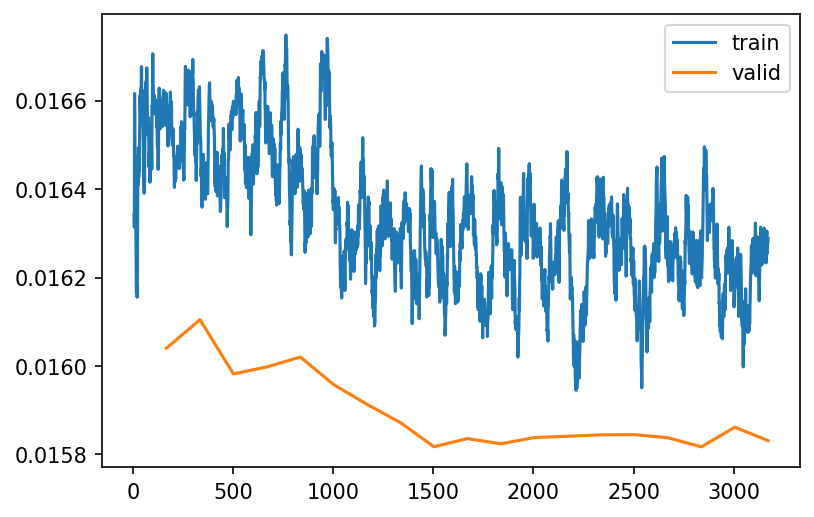

Best validation score: 0.01581701450049877.


============================== Round 2 ==============================
TabularModel(
  (embeds): ModuleList(
    (0): Embedding(3, 3)
    (1): Embedding(4, 3)
    (2): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.5, inplace=False)
  (bn_cont): BatchNorm1d(872, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): BatchNorm1d(881, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.8, inplace=False)
      (2): Linear(in_features=881, out_features=2018, bias=False)
      (3): ReLU(inplace=True)
    )
    (1): LinBnDrop(
      (0): BatchNorm1d(2018, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.6, inplace=False)
      (2): Linear(in_features=2018, out_features=1024, bias=False)
      (3): ReLU(inplace=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=1024, out_features=206, bias=True)
    )
  )
)


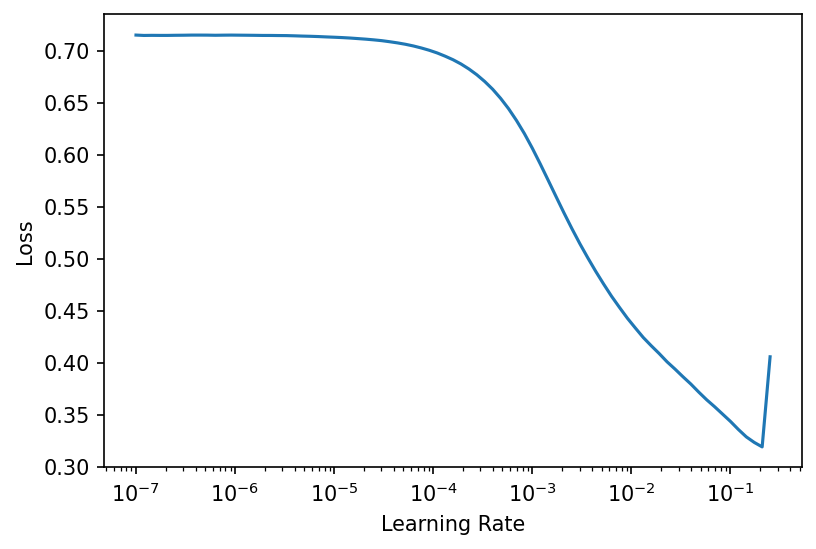

epoch,train_loss,valid_loss,time
0,0.024522,0.019079,00:02
1,0.023186,0.019473,00:02
2,0.020260,0.019396,00:02
3,0.019222,0.017885,00:02
4,0.018614,0.017412,00:02
5,0.018096,0.017162,00:02
6,0.017665,0.016980,00:02
7,0.017384,0.016417,00:02
8,0.016878,0.016313,00:02
9,0.016716,0.016254,00:02


epoch,train_loss,valid_loss,time
0,0.016637,0.016181,00:02
1,0.016739,0.016204,00:02
2,0.016823,0.016146,00:02
3,0.016814,0.016117,00:02
4,0.016574,0.016097,00:02
5,0.016624,0.016017,00:02
6,0.016539,0.015992,00:02
7,0.016488,0.015977,00:02
8,0.016501,0.016025,00:02
9,0.016609,0.015985,00:02


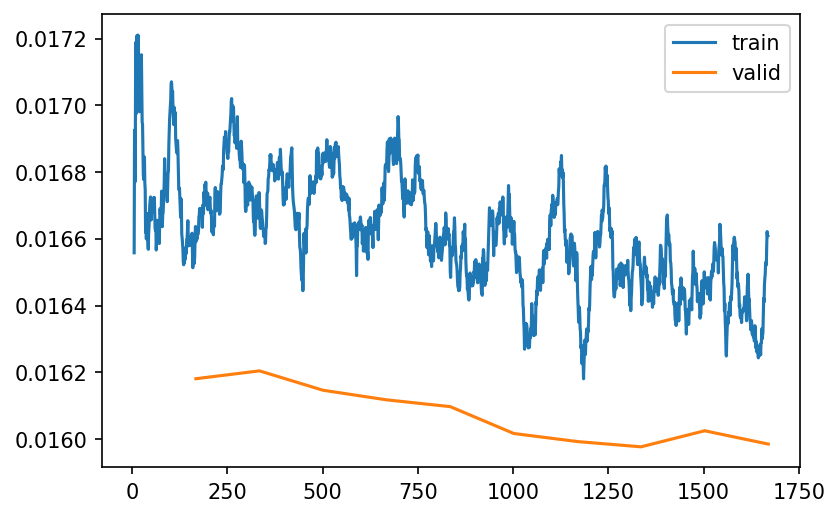

epoch,train_loss,valid_loss,time
0,0.016541,0.015975,00:02
1,0.016499,0.015988,00:02
2,0.016577,0.016014,00:02
3,0.016491,0.015949,00:02
4,0.016429,0.016022,00:02
5,0.016417,0.015932,00:02
6,0.016352,0.015872,00:02
7,0.016222,0.015896,00:02
8,0.016048,0.015899,00:02
9,0.016261,0.015872,00:02


Better model found at epoch 0 with valid_loss value: 0.01597507670521736.
Better model found at epoch 3 with valid_loss value: 0.015948783606290817.
Epoch 5: reducing lr to 0.0001
Better model found at epoch 5 with valid_loss value: 0.01593214087188244.
Better model found at epoch 6 with valid_loss value: 0.015871552750468254.
Epoch 10: reducing lr to 1e-05
Better model found at epoch 10 with valid_loss value: 0.015838265419006348.
Better model found at epoch 11 with valid_loss value: 0.015834618359804153.
Better model found at epoch 12 with valid_loss value: 0.015831438824534416.
Epoch 15: reducing lr to 1.0000000000000002e-06
Better model found at epoch 17 with valid_loss value: 0.01582050323486328.
Epoch 20: reducing lr to 1.0000000000000002e-07
Epoch 25: reducing lr to 1.0000000000000002e-08
No improvement since epoch 17: early stopping


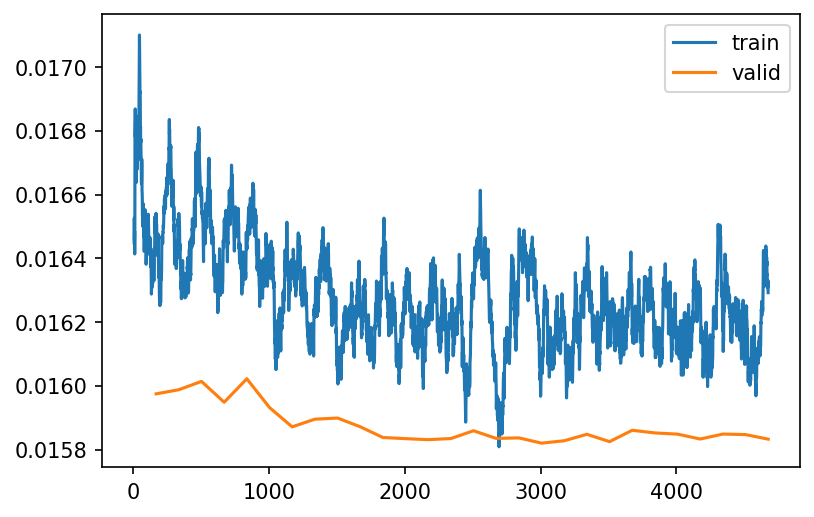

Best validation score: 0.01582050323486328.


============================== Round 3 ==============================
TabularModel(
  (embeds): ModuleList(
    (0): Embedding(3, 3)
    (1): Embedding(4, 3)
    (2): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.5, inplace=False)
  (bn_cont): BatchNorm1d(872, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): BatchNorm1d(881, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.8, inplace=False)
      (2): Linear(in_features=881, out_features=2018, bias=False)
      (3): ReLU(inplace=True)
    )
    (1): LinBnDrop(
      (0): BatchNorm1d(2018, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.6, inplace=False)
      (2): Linear(in_features=2018, out_features=1024, bias=False)
      (3): ReLU(inplace=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=1024, out_features=206, bias=True)
    )
  )
)


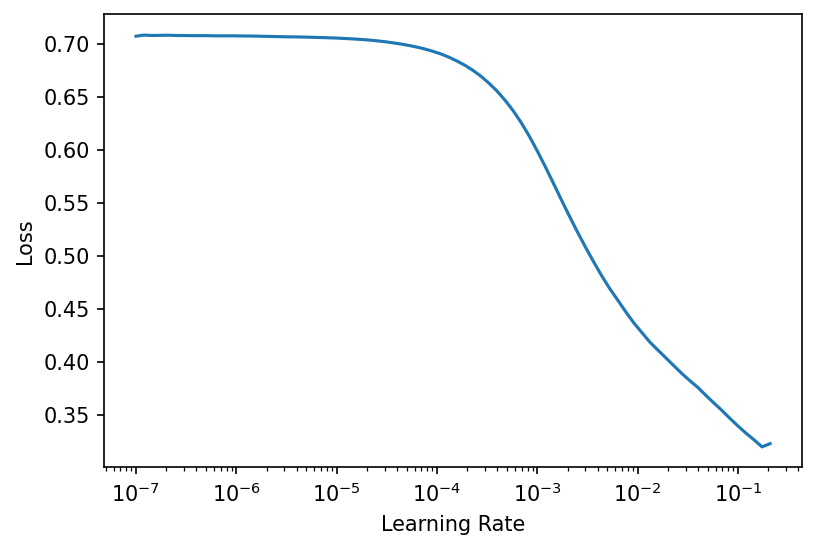

epoch,train_loss,valid_loss,time
0,0.024546,0.019355,00:02
1,0.022988,0.018933,00:02
2,0.020340,0.018543,00:02
3,0.019217,0.017736,00:02
4,0.018686,0.017644,00:02
5,0.018078,0.017220,00:02
6,0.017789,0.016881,00:02
7,0.017388,0.016523,00:02
8,0.016765,0.016211,00:02
9,0.016728,0.016189,00:02


epoch,train_loss,valid_loss,time
0,0.016793,0.016128,00:02
1,0.016826,0.016195,00:02
2,0.016645,0.016107,00:02
3,0.016521,0.016052,00:02
4,0.016599,0.016053,00:02
5,0.016555,0.016014,00:02
6,0.016453,0.015948,00:02
7,0.016506,0.015938,00:02
8,0.016448,0.015946,00:02
9,0.016289,0.015937,00:02


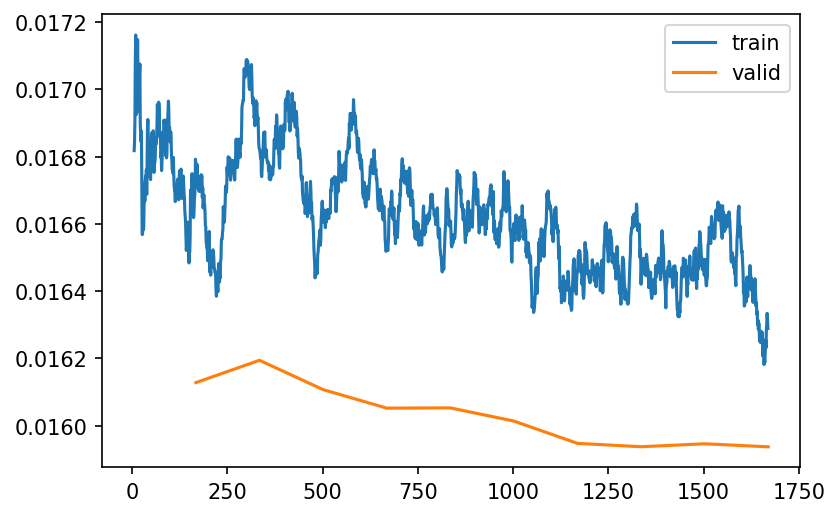

epoch,train_loss,valid_loss,time
0,0.016553,0.015934,00:02
1,0.016372,0.015993,00:02
2,0.016589,0.015929,00:02
3,0.016645,0.015949,00:02
4,0.016649,0.015944,00:02
5,0.016357,0.015899,00:02
6,0.016247,0.015877,00:02
7,0.016288,0.015875,00:02
8,0.016304,0.015868,00:02
9,0.016260,0.015826,00:02


Better model found at epoch 0 with valid_loss value: 0.015933595597743988.
Better model found at epoch 2 with valid_loss value: 0.015928836539387703.
Epoch 5: reducing lr to 0.0001
Better model found at epoch 5 with valid_loss value: 0.01589852012693882.
Better model found at epoch 6 with valid_loss value: 0.01587739586830139.
Better model found at epoch 7 with valid_loss value: 0.015874573960900307.
Better model found at epoch 8 with valid_loss value: 0.01586756482720375.
Better model found at epoch 9 with valid_loss value: 0.015826081857085228.
Epoch 10: reducing lr to 1e-05
Better model found at epoch 10 with valid_loss value: 0.01581191085278988.
Better model found at epoch 11 with valid_loss value: 0.01578805036842823.
Epoch 15: reducing lr to 1.0000000000000002e-06
Epoch 20: reducing lr to 1.0000000000000002e-07
No improvement since epoch 11: early stopping


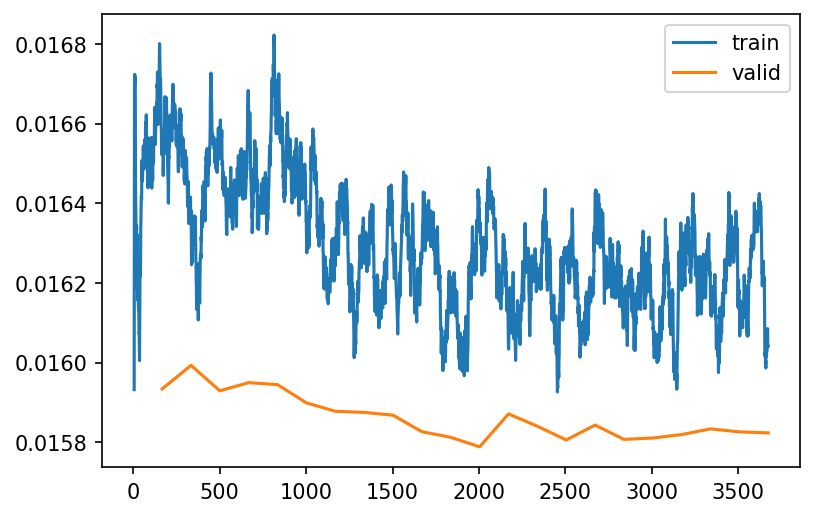

Best validation score: 0.01578805036842823.


============================== Round 4 ==============================
TabularModel(
  (embeds): ModuleList(
    (0): Embedding(3, 3)
    (1): Embedding(4, 3)
    (2): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.5, inplace=False)
  (bn_cont): BatchNorm1d(872, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): BatchNorm1d(881, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.8, inplace=False)
      (2): Linear(in_features=881, out_features=2018, bias=False)
      (3): ReLU(inplace=True)
    )
    (1): LinBnDrop(
      (0): BatchNorm1d(2018, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.6, inplace=False)
      (2): Linear(in_features=2018, out_features=1024, bias=False)
      (3): ReLU(inplace=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=1024, out_features=206, bias=True)
    )
  )
)


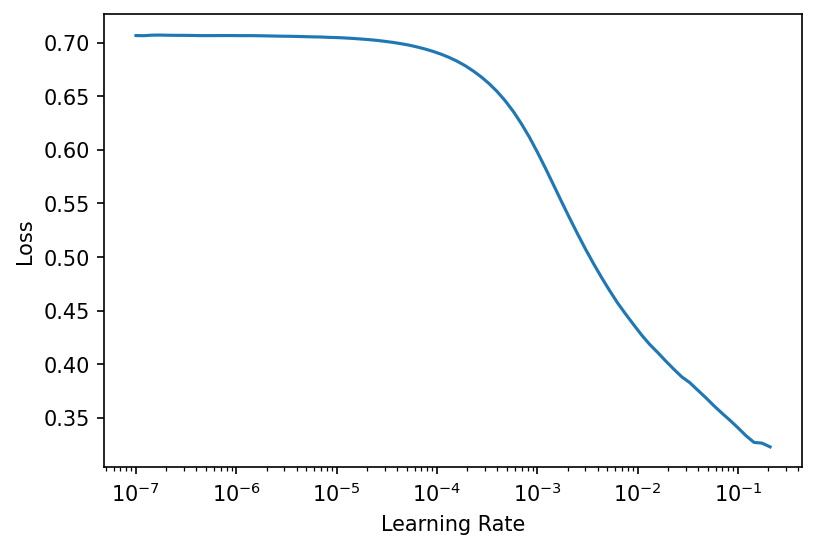

epoch,train_loss,valid_loss,time
0,0.024304,0.019596,00:02
1,0.022728,0.020000,00:02
2,0.020059,0.018493,00:02
3,0.019133,0.018917,00:02
4,0.018460,0.017947,00:02
5,0.018135,0.016910,00:02
6,0.017689,0.016751,00:02
7,0.017025,0.016545,00:02
8,0.016867,0.016366,00:02
9,0.016944,0.016177,00:02


epoch,train_loss,valid_loss,time
0,0.016971,0.016207,00:02
1,0.016922,0.016207,00:02
2,0.016651,0.016137,00:02
3,0.016783,0.016066,00:02
4,0.016848,0.016092,00:02
5,0.016585,0.016010,00:02
6,0.016612,0.016039,00:02
7,0.016357,0.016024,00:02
8,0.016618,0.015979,00:02
9,0.016322,0.015970,00:02


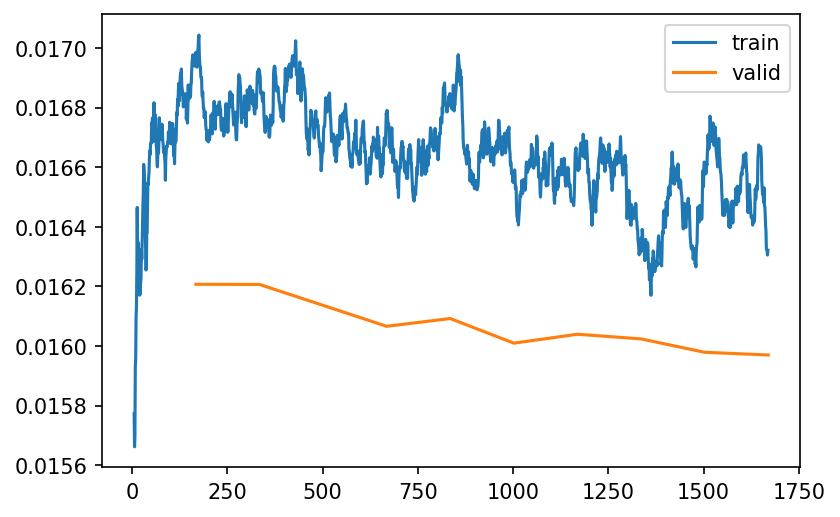

epoch,train_loss,valid_loss,time
0,0.016445,0.016009,00:02
1,0.016508,0.015976,00:02
2,0.016324,0.015953,00:02
3,0.016382,0.015976,00:02
4,0.016367,0.016037,00:02
5,0.016252,0.015966,00:02
6,0.016276,0.015885,00:02
7,0.016230,0.015836,00:02
8,0.016272,0.015884,00:02
9,0.016209,0.015844,00:02


Better model found at epoch 0 with valid_loss value: 0.016008827835321426.
Better model found at epoch 1 with valid_loss value: 0.015976399183273315.
Better model found at epoch 2 with valid_loss value: 0.015953097492456436.
Epoch 5: reducing lr to 0.0001
Better model found at epoch 6 with valid_loss value: 0.0158847663551569.
Better model found at epoch 7 with valid_loss value: 0.01583615504205227.
Epoch 10: reducing lr to 1e-05
Better model found at epoch 12 with valid_loss value: 0.015820425003767014.
Epoch 15: reducing lr to 1.0000000000000002e-06
Epoch 20: reducing lr to 1.0000000000000002e-07
No improvement since epoch 12: early stopping


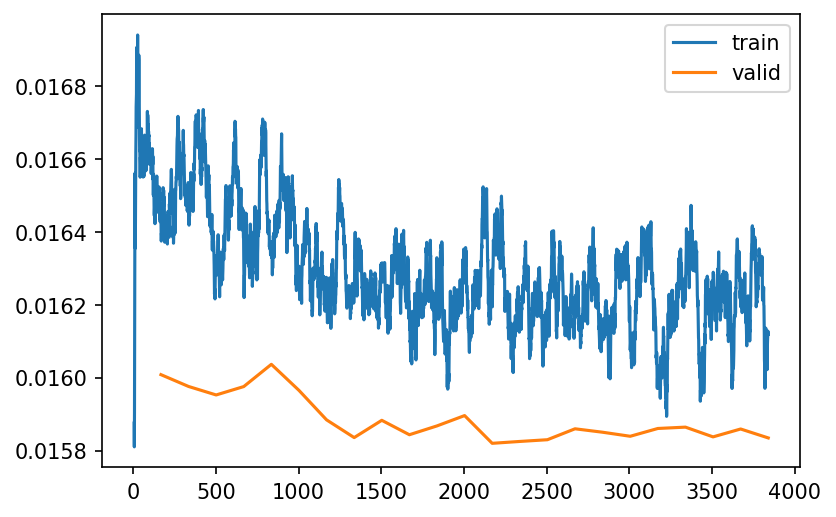

Best validation score: 0.015820425003767014.


In [9]:
preds = []

for i in tqdm( range(5) ):
    print('='*30+f' Round {i} '+'='*30)
    learn = tabular_learner(dls, layers=layers, 
                            config=config, opt_func=Adam,
                            loss_func=BCEWithLogitsLossFlat())
    print(learn.model)
    learn = fitting_procedure(learn)

    val_score = learn.validate()[0]
    
    print(f'Best validation score: {val_score}.')
    min_val_score = val_score
    preds.append( predict(learn,test) )

In [10]:
print('Done')

Done


In [11]:
pred = np.array(preds).mean(axis=0)

create_submission(from_numpy=pred, test=test)

array([[1.0424302e-03, 1.1053127e-03, 9.1275282e-04, ..., 1.0001421e-03,
        1.1719895e-03, 1.1517743e-03],
       [3.0801800e-04, 8.7852951e-04, 6.2185305e-04, ..., 4.7730491e-04,
        1.1213820e-03, 9.2021516e-04],
       [5.5142638e-05, 1.5873284e-05, 7.5128675e-04, ..., 1.5239213e-03,
        8.3321444e-04, 1.0473714e-03],
       ...,
       [1.6737714e-03, 1.0268155e-03, 5.4598117e-04, ..., 9.0873364e-04,
        1.0258092e-03, 1.4618855e-03],
       [9.5387979e-04, 7.6090824e-04, 1.1629723e-03, ..., 1.5250121e-03,
        1.7489024e-03, 2.0953708e-03],
       [8.8964560e-04, 9.2689460e-04, 8.2064589e-04, ..., 9.8133832e-04,
        9.8144321e-04, 1.1127254e-03]], dtype=float32)

In [12]:
! ls

__notebook__.ipynb  models  submission.csv


In [13]:
pred.shape

(3982, 206)